<a href="https://colab.research.google.com/github/ebeltyukova/bipn164/blob/main/Liza_BIPN164_HW1_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

$\textbf{Name}:$   Elizaveta Beltyukova                      

# BIPN 164: Homework #1

### Due **04-21-2024 at 11:59 PM**. Please justify all your answers.

If you have any questions, please email your TA Sowmya Manojna (smnarasimha@ucsd.edu).

# Instructions:

**To start working on this Homework, create a copy of this notebook and save it within your Google Drive (File -> Save a copy in Drive).**

This Jupyter notebook contains exercises consisting of coding and discussion questions. **For the discussion questions, please write your answer within a new markdown/text cell**. Please submit in your .ipynb file (File -> Download -> Download .ipynb) on canvas by **11:59 PM** on **Monday April 21**.

To execute the code, it is necessary to load some external packages, so please execute the following code block.

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.integrate import odeint
from scipy.signal import find_peaks

# 1. Hodgkin-Huxley Model

To implement the HH model, you will need to implement the equations to model the Sodium, Potassium, and Leak currents:

All the equations necessary to model the Sodium current:

\begin{align}
  I_{Na}   &= \bar{g}_{Na} m^3 h (V-E_{Na})\\
  \frac{dm}{dt} &= -\frac{1}{\tau_m (V)}[m-m_\infty(V)] \\
  \alpha_m &= 0.1 \frac{V+40}{1-e^{-\frac{V+40}{10}}} \\
  \beta_m  &= 4 e^{-\frac{V+65}{18}} \\
  \tau_m &= \frac{1}{\alpha_m(V) + \beta_m(V)} \\
  m_\infty &= \frac{\alpha_m(V)}{\alpha_m(V) + \beta_m(V)}\\
  \frac{dh}{dt} &= -\frac{1}{\tau_h (V)}[h-h_\infty(V)] \\
  \alpha_h &= 0.07 e^{-\frac{V+65}{20}} \\
  \beta_h  &= \frac{1}{1+e^{-\frac{V+35}{10}}} \\
  \tau_h &= \frac{1}{\alpha_h(V) + \beta_h(V)} \\
  h_\infty &= \frac{\alpha_h(V)}{\alpha_h(V) + \beta_h(V)}\\
\end{align}

All the equations necessary to model the Potassium current:
\begin{align}
  I_{K}   &= \bar{g}_{K} n^4 (V-E_{K})\\
  \frac{dn}{dt} &= -\frac{1}{\tau_n (V)}[n-n_\infty(V)] \\
  \alpha_n &= 0.01 \frac{V+55}{1-e^{-\frac{V+55}{10}}} \\
  \beta_n  &= 0.125 e^{-\frac{V+65}{80}}\\
  \tau_n &= \frac{1}{\alpha_n(V) + \beta_n(V)} \\
  n_\infty &= \frac{\alpha_n(V)}{\alpha_n(V) + \beta_n(V)}\\
\end{align}

All the equations to model the Leak current:
\begin{align}
  I_{L}   &= \bar{g}_{L} (V-E_{L})\\
\end{align}

Finally, the equation to model the change in the membrane potential due to some injected current $I_{inj}$:
\begin{align}
\frac{dV}{dt} &= \frac{1}{C_m}(I_{inj}(t) - I_{Na} - I_K - I_L)\\
\frac{dV}{dt} &= \frac{1}{C_m}(I_{inj}(t) - I_{ion})\\
\end{align}

In [ ]:
def HHModel(y, t, I_inj_param):
    """The description of ODEs in Hodgkin-Huxley Model.

    Basically this function describes the change of system in *one simulation step*.
    It shows of the HHModel, i.e., how `V, m, n, h` changes within the given dt.
    Notice that this function will be passed to `scipy.integrate.odeint` function for solving.

    Args:
        y (vector of float): A vector of status variables at current timestamp, i.e. [V, m, n, h].
        t (float): Current timestamp
        I (tuple of float): The inject current with its start/end timestamp, (I_inject, t_start, t_end)

    Returns:
        np.array: a vector, [dV/dt, dm/dt, dn/dt, dh/dt].
    """
    V, m, n, h = y

    # computing the injected current for the present timestep.
    I_inj, t_start, t_end = I_inj_param[0], I_inj_param[1], I_inj_param[2]
    if t > t_start and t < t_end:
        I_inj = I_inj
    else:
        I_inj = 0

    # Constants
    C_m  =   1.0 # membrane capacitance, in uF/cm^2
    g_Na = 120.0 # maximum conductances, in mS/cm^2
    g_K  =  36.0
    g_L  =   0.3
    E_Na =  50.0 # Nernst reversal potentials, in mV
    E_K  = -77.0
    E_L  = -54.387

    # Compute alpha and beta functions
    alpha_m = 0.1*(V+40.0)/(1.0-np.exp(-(V+40.0)/10.0))
    beta_m  = 4.0*np.exp(-(V+65.0)/18.0)
    alpha_h = 0.07*np.exp(-(V+65.0)/20.0)
    beta_h  = 1.0/(1.0+np.exp(-(V+35.0)/10.0))
    alpha_n = 0.01*(V+55.0)/(1.0-np.exp(-(V+55.0)/10.0))
    beta_n  = 0.125*np.exp(-(V+65)/80.0)

    # TODO: Compute membrane currents
    # You could define I_ion to be the sum of all ion currents involved
    I_Na  = g_Na * m**3 * h * (V - E_Na)
    I_K   = g_K * n**4 * (V - E_K)
    I_L   = g_L * (V - E_L)
    I_ion = I_Na + I_K + I_L

    # Compute voltage dependent timescales and steady-state values
    tau_m = 1.0 / (alpha_m + beta_m)
    m_inf = alpha_m / (alpha_m + beta_m)
    tau_h = 1.0 / (alpha_h + beta_h)
    h_inf = alpha_h / (alpha_h + beta_h)
    tau_n = 1.0 / (alpha_n + beta_n)
    n_inf = alpha_n / (alpha_n + beta_n)

    # TODO: Compute derivatives
    dVdt = (1/C_m) * (I_inj - I_Na - I_K - I_L)
    dmdt = - 1/tau_m * (m - m_inf)
    dndt = - 1/tau_n * (n - n_inf)
    dhdt = - 1/tau_h * (h - h_inf)

    return np.array([dVdt, dmdt, dndt, dhdt])


As a validation of the model that you implemented, use the initial condition:

$$
\begin{align}
V & = -63\\
m & = 0.0530\\
n & = 0.3177\\
h & = 0.5961
\end{align}
$$

and set the simulation time to be 500 ms.

(-80.0, 50.0)

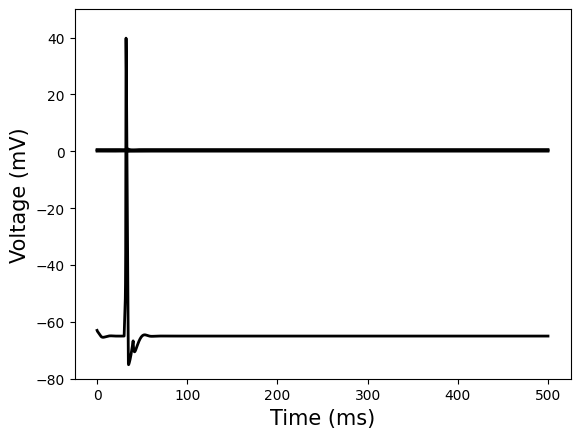

In [ ]:

# TODO: Set the initial condition for the HH Model
initial = [-63, 0.0530, 0.3177, 0.5961]
T_total = 500 # in ms
dt = 0.1  # in ms
t = np.linspace(0, T_total, int(T_total/dt)+1)

# The properties of the input current pulse are defined using a tuple
# The 1st number is the amplitude of the input current pulse in uA/cm^2
# The 2nd number is the start time of the pulse in ms
# The 3rd number is the end   time of the pulse in ms
I_inj_param = (10, 30, 40) # a test case for input current

# Use odeint function to simulate the system
y = odeint(HHModel, initial, t, args=(I_inj_param,))

# TODO: Read out the voltage
V = y[:,0]

# TODO: Plot the Voltage
plt.plot(t, y, color = "black", label = "V(t)", lw = 2)
plt.xlabel('Time (ms)', fontsize=15)
plt.ylabel('Voltage (mV)', fontsize=15)
plt.ylim(-80.0, 50.0)

If everything works fine, you should expect to see a figure like this:

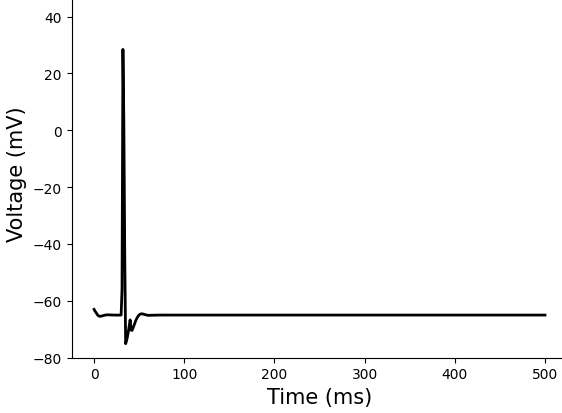

## 1.1: Spike train generation (30 points)

Now we use the HH Model we implemented to generate spikes. Please run the following code block for a convient plotting utility function.

In [ ]:
def plot_helper_function(t, V, I_inj_param, hline = False):
    (I_current_amplitude, t_current_start, t_current_end) = I_inj_param
    # Generate the array for input current pulse
    I_inj = np.zeros_like(t)
    # Now visualize the stimulus
    for i in range(len(t)):
        if (t[i] >= t_current_start) and (t[i]<=t_current_end):
            I_inj[i] = I_current_amplitude
        else:
            I_inj[i] = 0


    fig, ax_volt = plt.subplots()
    ax_stim = ax_volt.twinx()

    ln1 = ax_volt.plot(t, V, color = "black", label = "V(t)", lw = 2)
    ax_volt.set_xlabel('Time (ms)', fontsize=15)
    ax_volt.set_ylabel('Voltage (mV)', fontsize=15)
    ax_volt.set_ylim(-85.0, 50.0)
    if hline:
        ax_volt.axhline(y=0, color='gray', linestyle='--')

    ln2 = ax_stim.plot(t, I_inj, color = "red", label = "I_stim(t)", lw=1)
    ax_stim.set_ylabel('Stimulus Current (\u00B5A/cm\u00B2)', fontsize=15)
    ax_stim.set_ylim(-1, 21)

    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax_volt.legend(lns, labs, loc=0)

    plt.title('Input Current = {} (\u00B5A/cm\u00B2), for {} ms'.format(I_current_amplitude, t_current_end - t_current_start), fontweight='bold', fontsize=14)
    plt.show()

### 1.1(a) Qualitative Analysis (10 points)
In this section you will be asked to simulate different conditions and qualitatively analyze the behavior of an HH model.

- We will use the same initial conditions shown before and keep the simulation duration 500ms.

- Simulate input current pulses with 4 different amplitudes
  - 0 $\mu$A/cm$^2$
  - 6 $\mu$A/cm$^2$
  - 10.7 $\mu$A/cm$^2$
  - 20 $\mu$A/cm$^2$

- For each amplitude, simulate input current pulses of 2 different durations
  - 2 ms
  - 20 ms

- Plot the membrane potential $V$ as a function of time, using the `plot_helper_function` above.

- Questions:
  - Explain the differences in action potentials for different conditions. Qualitatively describe the dependence of the action potential shape as a function of input width/amplitude.

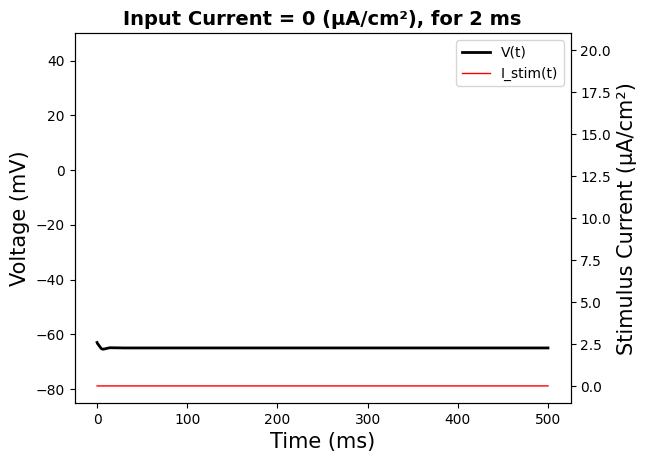

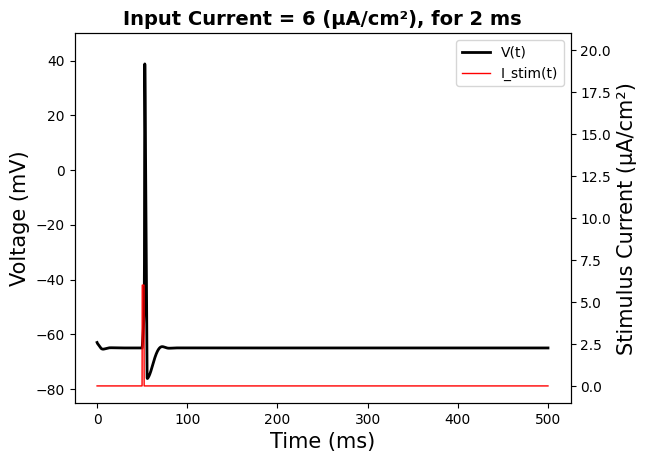

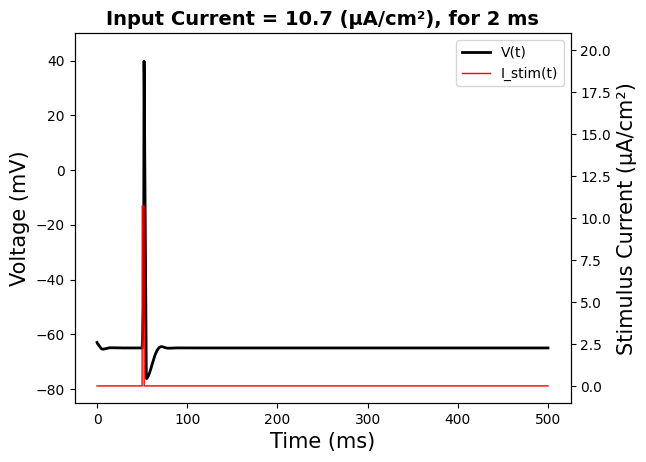

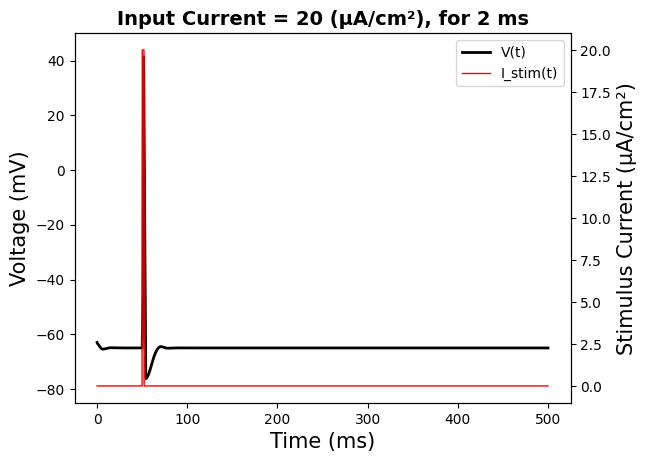

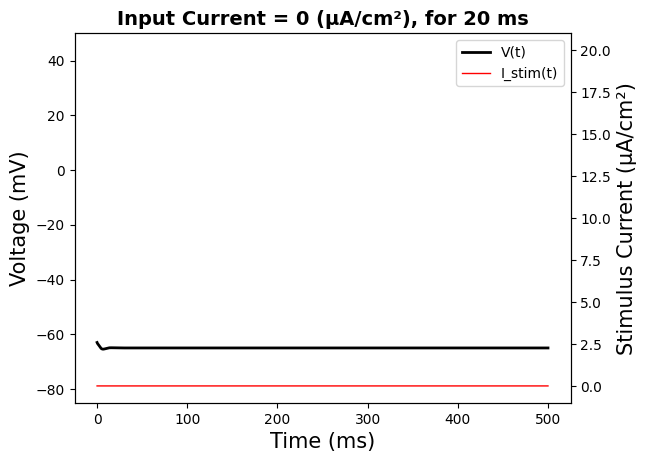

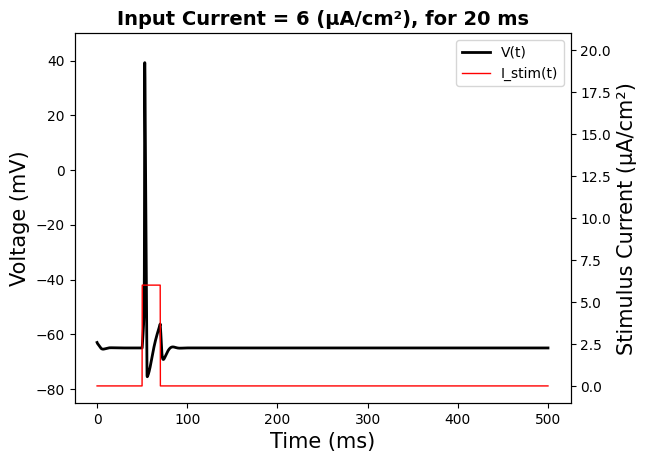

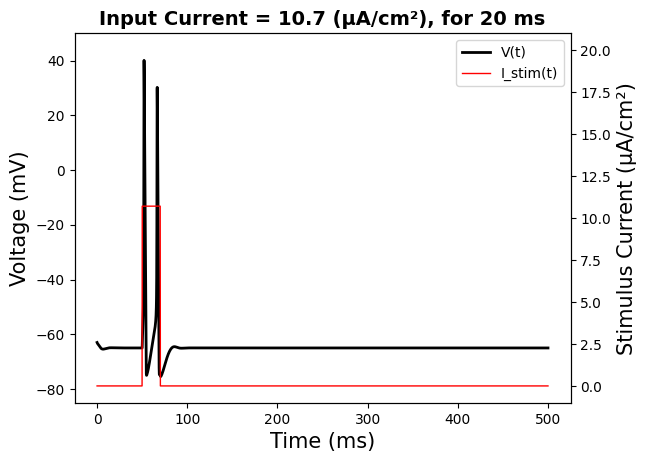

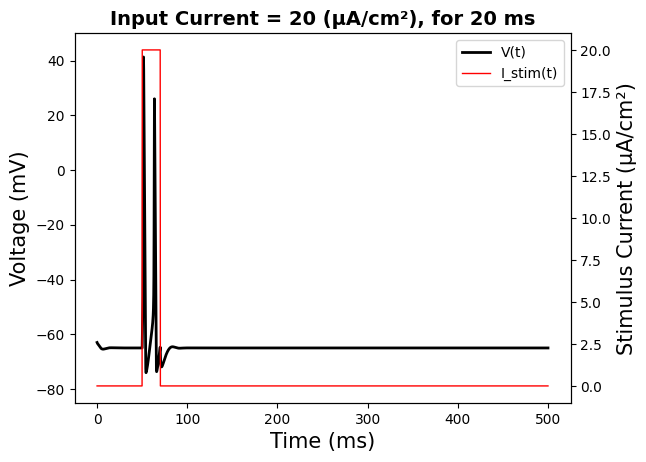

In [ ]:
# TODO: Set the simulation time and current input
T_total = 500 # ms
dt = 0.1  # temporal resolution in ms
t = np.linspace(0, T_total, int(T_total/dt)+1)

# TODO: set external current amplitudes
I_current_amplitude_list = [0, 6, 10.7, 20] # microA/cm^2
t_current_start = 50            # input current pulse will start at this time
t_current_end_list = [52, 70] # input current pulse will end at this time

# Solve the differential equation using odeint
# t_idx is the index of t_current_end, t0 is the value
# i.e t_idx = 0,1 and t0 = endpoint1,endpoint2
for t_idx, t_current_end in enumerate(t_current_end_list):
    for i_idx, I_current_amplitude in enumerate(I_current_amplitude_list):  # loop over different amplitudes
        I_inj_param = (I_current_amplitude, t_current_start, t_current_end)

        # Solve the differential equation using odeint
        y = odeint(HHModel, initial, t, args=(I_inj_param,)) # integrate the values over time

        # TODO: read out V, m, h and n
        V, m, n, h = y[:,0], y[:,1], y[:,2], y[:,3]
        # m represents the activation of the sodium (Na+) channels.
        # n represents the activation of the potassium (K+) channels.
        # h represents the inactivation of the sodium (Na+) channels.

        plot_helper_function(t, V, I_inj_param)

Explain the differences in action potentials for different conditions. Qualitatively describe the dependence of the action potential shape as a function of input width/amplitude.



### 1.1(b) Quantitative Analysis of the threshold (10 points)
In this section you will be asked to analyze the model quantitatively. Specifically, you are asked to find the *threshold* of the current input that will elicit a spike.

- As before, simulate the HH Model over 500ms using the same initial condition. This time, try to modify the amplitude of input current pulse with a fixed duration **2ms**.

- Questions:
    1. What is the minimal current input that will elicit a spike?
    2. For the largest input current that *does not* elicit a spike, what is the maximal membrane potential reached?
    3. Change the duration of input current. Explain why and how the threshold is sensitive to the duration.

In [ ]:
# TODO: Set the simulation time and current input
T_total = ... # ms
dt = 0.1  # temporal resolution in ms
t = np.linspace(0, T_total, int(T_total/dt)+1)

# TODO: Test different value here and find minimal current that will elicit a spike
I_current = ... # microA/cm^2

t_current_start = 50 # input current pulse will start at this time
t_current_end   = ... # input current pulse will end at this time

I_inj_param = (I_current, t_current_start, t_current_end)
y = odeint(HHModel, initial, t, args=(I_inj_param,)) # integrate the values over time

# TODO: Read out V
V = ...

plot_helper_function(t, V, I_inj_param)

print("The maximal membrane potential reached")
print(np.max(V))

### 1.1(c) Quantitative Analysis of the amplitude (10 points)
Here you will be asked about the response of the neuron driven by a constant (sustained) input current. In this condition the neuron's response can be a sequence ("train") of spikes.
- Simulate the Hodgkin-Huxley Model over 500ms using the same initial condition. This time, however, the *current will be injected throughout the simluation*.
- Find the minimal injected current that will generate a sustained spike train. Describe the shape of the action potential.

- Questions:
    1. What is the minimal injected current that can generate a sustained spike train?
    2. Describe the shape of the spikes. How are they different from each other?

In [ ]:
# Set the simulation time and current input
T_total = ... # ms
dt = 0.1  # temporal resolution in ms
t = np.linspace(0, T_total, int(T_total/dt)+1)

# TODO: Again, test different values here and find minimal current that will generate a sustained spike train
I_current = ... # microA/cm^2
# TODO: Set the current time step to span throughout the simulatuion
t_current_start = ... # in ms
t_current_end  = ...  # in ms

# Solve the differential equation using odeint
I_inj_param = (I_current, t_current_start, t_current_end)
y = odeint(HHModel, initial, t, args=(I_inj_param,)) # integrate the values over time

# TODO: readout V
V = ...

plot_helper_function(t, V, I_inj_param, hline=True)

## 1.2: Firing rate vs Current (20 points)
We have already shown that under certain circumstances we can obtain a sustained spike train. Now we are interested in the *frequency* $f$ of the spikes the neuron generates.

- Run the simulation using a *constant* input current with amplitude 10 $\mu$A/cm$^2$.
- Count the number of spikes in a window of fixed size.
  - Hint: you can use the [`find_peaks()`](https://urldefense.com/v3/__https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html__;!!Mih3wA!GiSKrr5y7MsYaNBWAChf0dVwgwn6N9YnGrCn9K0o1UpdNRBKxXOIsFAnRqxAFmXYDUpjdZ343v2VrSKm$ ) function from scipy.signal to find when the model neuron spikes.
- Plot the "f-I curve" (the frequency of spikes as a function of the input current).

In [ ]:
# Here we will simulate the HH model in a finer temporal resolution (0.05ms)
# for an accurate statistics of spike numbers
T_total = 500 # ms
dt = 0.05 #ms
t = np.linspace(0, T_total, int(T_total / dt) + 1)

# TODO: Constant input with amplitude 10 microA/cm^2
I_current = ... # microA/cm^2
t_current_start = ... # in ms
t_current_end   = ... # in ms

I_inj_param = (I_current,t_current_start,t_current_end)
y = odeint(HHModel, initial, t, args=(I_inj_param,))

# TODO: Read out V
V = ...

plt.plot(t, V)

# TODO: Locate all the spikes using find_peak functions
peaks, _ = find_peaks(..., ...) # use a height of 10 at this step. See the doucmetation for more details
num_peaks = ...


plt.plot(t[peaks], V[peaks], "x", label=f"{num_peaks} peaks above 10 mV")
plt.legend()
plt.ylabel('Voltage (mV)', fontsize=15)
plt.xlabel('Time t (ms)', fontsize=15)
plt.show()

# Counting the number of peaks
print('Number of peaks:', num_peaks)


- Now, loop over a range of input amplitude and calculate the firing rates corresponding to different amplitudes. Remember to correctly convert the spike count to spike rate in the units of Hz = 1/s.
    - Remember that the T_total is in milliseconds!!
- Then, plot the firing rate - amplitude (f-I) curve.

- Questions:
  1. In words, can the H-H neuron model be driven at an arbitrarily high frequency?
  2. Does the voltage amplitude of the spikes change for different current amplitudes? Hint: It may be necessary to adjust the `height` parameter used in the `find_peaks` function.

In [ ]:
# Set a range of current inputs
I_current_list = np.arange(1, 60, 3)
t_current_start = 0 # input current pulse will start at this time
t_current_end   = T_total # input current pulse will end at this time

# Preallocate a vector for storing the spike counts and peak amplitudes
spike_rate = np.zeros(len(I_current_list))

for i_idx, I_current in enumerate(I_current_list):
    # TODO: Implement the simulation yourself

    V = ...

    peaks, _ = find_peaks(..., ...) # Play around with height and see what happens when you change this threshold

    # TODO: convert the number of spikes into spike rates in s^-1
    spike_rate[i_idx] = ...
    print("Input Current = {} μA/cm$^2$, spike rate = {} s^-1".format(I_current, spike_rate[i_idx]))

In [ ]:
# TODO: plot the f-I curve
plt.plot(I_current_list, spike_rate, '-o')
plt.xlabel('Applied Current (μA/cm$^2$)')
plt.ylabel(r'Avg Spike Rate ($s^{-1}$)')
plt.title("F-I curve")
plt.show()

## 1.3: Correlated Variables (10 points)
In this section we will study the dynamics of the H-H Model deeper by looking at relationships between the variables $m$, $h$, and $n$.

- Simulate the system under a constant current input with amplitude 10 $\mu$A/cm$^2$.
- For each pair of variables $V$, $m$, $h$, $n$ (6 pairs), plot one variable as a function of the other.
- Compute the correlation between each pair and identify pairs that are most strongly correlated.

- Questions:
    1. How can this identification help in reducing the model neuron's dimension?
    2. Change the input amplitude. Does the choice of current amplitude affect which pairs of variables are most correlated?

In [ ]:
# TODO: Provided below is a SAMPLE of how to plot 6 plots at once. Run this code block to see the example
# Change the code to plot V vs m, V vs n, V vs h, n vs m, n vs h, h vs m

x = np.linspace(0, 2*np.pi, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = np.tan(x)
y4 = np.exp(-x)
y5 = np.sqrt(x)
y6 = np.log(x[1:])

# Create a figure with 6 subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

# Plot data on each subplot
axes[0, 0].plot(x, y1)
axes[0, 0].set_title('sin(x)')

axes[0, 1].plot(x, y2)
axes[0, 1].set_title('cos(x)')

axes[0, 2].plot(x, y3)
axes[0, 2].set_title('tan(x)')

axes[1, 0].plot(x, y4)
axes[1, 0].set_title('exp(-x)')

axes[1, 1].plot(x, y5)
axes[1, 1].set_title('sqrt(x)')

axes[1, 2].plot(x[1:], y6)
axes[1, 2].set_title('log(x)')

# Add global labels and title
fig.suptitle('Six Subplots')
fig.text(0.5, 0.04, 'x', ha='center', fontsize=12)
fig.text(0.04, 0.5, 'y', va='center', rotation='vertical', fontsize=12)

# Adjust spacing and layout
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Show the plot
plt.show()

In [ ]:
T_total = 500 # ms
dt = 0.05 #ms
t = np.linspace(0, T_total, int(T_total / dt) + 1)

# TODO: set amplitude above the spiking threshold. Does this choice affect correlation?
I_current = 6 # microA/cm^2
t_current_start = 0
t_current_end   = T_total

# To Do: Run Simulations
...

# TODO: Get the V(t), m(t), n(t), h(t)
V, m, n, h = ...

In [ ]:
# Identify pairs that are most strongly correlated

# Put each variable in a dataframe
data = {'V': V, 'm': m, 'n': n, 'h': h}

# Create a dataframe using the dictionary
df = pd.DataFrame(data)

# Print the dataframe
display(df)

In [ ]:
# TODO: calculate the correlation matrix
corr_matrix = ...

# Print the correlation matrix
print(corr_matrix)

plt.title("Correlation Matrix")
sns.heatmap(corr_matrix, annot=np.round(corr_matrix, 2))
plt.show()

## 1.4. Reducing the Hodgkin-Huxley Model (4D → 3D → 2D) (20 points)

Background:

The full Hodgkin-Huxley model describes the membrane potential dynamics using four variables:
- $V$: membrane potential
- $m$: Na⁺ activation gate
- $h$: Na⁺ inactivation gate
- $n$: K⁺ activation gate

However, under certain conditions, the system can be simplified to a 2-variable model by assuming that:
- $m$ has fast dynamics and instantaneously follows its steady-state value $m_\infty(V)$
- $h$ and $n$ are tightly coupled, such that $h=1−n$

This leads to a simplified model with just three or just two variables: $V$, $h$ and $n$ or just $V$ and $n$.

### 1.4(a) Hodgkin-Huxley 3D Model (10 Points)

In [ ]:
def Reduced_HHModel_3Var(y, t, I_inj_param):
    """
    3-variable HH model: V, h, n
    Fast m is replaced by m_inf(V)

    Args:
        y: [V, h, n]
        t: time (ms)
        I_inj_param: (I_inj, t_start, t_end)

    Returns:
        [dV/dt, dh/dt, dn/dt]
    """
    V, h, n = y

    # Injected current
    I_inj, t_start, t_end = I_inj_param
    I = I_inj if t_start < t < t_end else 0.0

    # Constants
    C_m = 1.0
    g_Na = 120.0
    g_K = 36.0
    g_L = 0.3
    E_Na = 50.0
    E_K = -77.0
    E_L = -54.387

    # Gating variables
    alpha_m = 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))
    beta_m  = 4.0 * np.exp(-(V + 65.0) / 18.0)
    m_inf = alpha_m / (alpha_m + beta_m)

    alpha_h = 0.07 * np.exp(-(V + 65.0) / 20.0)
    beta_h = 1.0 / (1.0 + np.exp(-(V + 35.0) / 10.0))
    h_inf = alpha_h / (alpha_h + beta_h)
    tau_h = 1.0 / (alpha_h + beta_h)

    alpha_n = 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))
    beta_n = 0.125 * np.exp(-(V + 65.0) / 80.0)
    n_inf = alpha_n / (alpha_n + beta_n)
    tau_n = 1.0 / (alpha_n + beta_n)

    # TODO: Compute membrane currents
    # Membrane currents
    I_Na  =
    I_K   =
    I_L   =
    I_ion =

    # TODO: Compute derivative
    # Derivatives
    dVdt =
    dhdt =
    dndt =

    return np.array([dVdt, dhdt, dndt])


In [ ]:
y0 = [-65.0, 0.6, 0.3177]  # Initial [V, h, n]
T_total = 500 # ms
dt = 0.05 #ms
t = np.linspace(0, T_total, int(T_total / dt) + 1)

I_inj_param = (10.0, 10.0, 60.0)

y = odeint(Reduced_HHModel_3Var, y0, t, args=(I_inj_param,))
V, h, n = ...

plot_helper_function(t, ..., I_inj_param, hline=True)

### 1.4(a) Hodgkin-Huxley 2D Model (10 Points)

In [ ]:
def Reduced_HHModel_2Var(y, t, I_inj_param):
    """
    Reduced 2-variable Hodgkin-Huxley Model: V and n.
    Assumes m = m_inf(V), and h = 1 - n.

    Args:
        y (list): [V, n] - membrane potential and K+ activation gate
        t (float): current time (ms)
        I_inj_param (tuple): (I_inj, t_start, t_end)

    Returns:
        np.array: [dV/dt, dn/dt]
    """
    V, n = y

    # Injected current
    I_inj, t_start, t_end = I_inj_param
    I = I_inj if t_start < t < t_end else 0.0

    # Constants
    C_m = 1.0   # uF/cm^2
    g_Na = 120.0  # mS/cm^2
    g_K  = 36.0
    g_L  = 0.3
    E_Na = 50.0   # mV
    E_K  = -77.0
    E_L  = -54.387

    # Gating variable kinetics (voltage-dependent)
    alpha_m = 0.1 * (V + 40.0) / (1 - np.exp(-(V + 40.0) / 10.0))
    beta_m  = 4.0 * np.exp(-(V + 65.0) / 18.0)
    m_inf = alpha_m / (alpha_m + beta_m)

    alpha_n = 0.01 * (V + 55.0) / (1 - np.exp(-(V + 55.0) / 10.0))
    beta_n  = 0.125 * np.exp(-(V + 65.0) / 80.0)
    n_inf = alpha_n / (alpha_n + beta_n)
    tau_n = 1 / (alpha_n + beta_n)

    # TODO: Compute membrane currents
    # Membrane currents
    I_Na  =
    I_K   =
    I_L   =
    I_ion =

    # TODO: Compute derivatives
    # Differential equations
    dVdt =
    dndt =

    return np.array([dVdt, dndt])

In [ ]:
# Initial conditions
y0 = [-65.0, 0.3177]

T_total = 500 # ms
dt = 0.05 #ms
t = np.linspace(0, T_total, int(T_total / dt) + 1)

# Injected current: 10 μA/cm² from 10 to 60 ms
I_inj_param = (10.0, 10.0, 60.0)

# Solve ODE
y = odeint(Reduced_HHModel_2Var, y0, t, args=(I_inj_param,))
V, n = ...

plot_helper_function(t, ..., I_inj_param, hline=True)

Plot the spikes produced by the three versions of the H-H model in response to the same input.
* Original model (4-dimensions).
* Model where $m = m_\infty$ (3-dimensions).
* Model where $m = m_\infty$ and $n = 1-h$ (2-dimensions).
Do you observe any differences in the shape of the spike in these versions of the model?
Can you explain those differences based on the approximations made to progressively simplify the model?

## 1.5 H-H model with a noisy input current (20 points)

In realistic conditions, the input to the neuron can be noisy. In this problem you are asked to simulate an H-H model with fluctuating input current. We will model the fluctuations of the input current as a Gaussian noise. In specific, the input current is determined by following function

$$
I_{inj}(t) = I_0 + \sigma \epsilon(t)
$$
where $I_{inj}$ and $\sigma$ are parameters and $\epsilon \sim \mathcal{N}(0, 1)$ is the Gaussian noise term.

- Simulate the system with this fluctuating input current.
- Plot multiple "f-I" curves with different $\sigma$ values. You can include
the curve obtained in 1.2 for $\sigma$=0 and compare cases with and without noise.

- TIPS:
    - This is a hard task that requires a little bit programming. Basically you will need to modify the `HHModel` function to support a new format of input. You can copy-paste the function and rename it to something like `HHModel_perturb`, and work on that new function so that you won't mess your previous function up.
    - Also, the plotting helper function will not work without modification. You can simply plot $V(t)$ like question 1.1.
    - You can use [`numpy.random.normal`](https://urldefense.com/v3/__https://numpy.org/doc/stable/reference/random/generated/numpy.random.normal.html__;!!Mih3wA!GiSKrr5y7MsYaNBWAChf0dVwgwn6N9YnGrCn9K0o1UpdNRBKxXOIsFAnRqxAFmXYDUpjdZ343ugIIjkT$ ) to generate samples from a gaussian distribution. Since randomness may introduce some debugging difficulties, you can use [`numpy.random.seed`](https://urldefense.com/v3/__https://numpy.org/doc/stable/reference/random/generated/numpy.random.seed.html__;!!Mih3wA!GiSKrr5y7MsYaNBWAChf0dVwgwn6N9YnGrCn9K0o1UpdNRBKxXOIsFAnRqxAFmXYDUpjdZ343v4GDJMu$ ) to generate the same numbers each time.
    - Do not generate random numbers within the `HHModel` function. The reason is that for the same time point `t`, this function will be called multiple times by `odeint`, and if you have different random numbers for the same t, the result will be unstable. Instead, pass some already generated random numbers to the function, and use it in the `HHModel` function.

You can use the following code base as a starting point. However, you are also encouraged to implement your own version.

In [ ]:
def HHModel_perturbation(y, t, I_inj_noised, t_total):
    """The description of ODEs in Hodgkin-Huxley Model.

    A H-H Model with noise upon the current injection
    Args:
        y (vector of float): A vector of status variables at current timestamp, i.e. [V, m, n, h].
        t (float): Current timestamp
        I_inj_noised(list of float): the injected current for each timestamp, the same length of total time points
        t_total (float): Total simulation time.
    Returns:
        np.array: a vector, [dV/dt, dm/dt, dn/dt, dh/dt].
    """
    V, m, n, h = y

    # computing the injected current for the present timestep.
    t_period_index = int(t / t_total * len(I_inj_noised))
    I_inj = I_inj_noised[t_period_index]

    # Constants
    C_m  =   1.0 # membrane capacitance, in uF/cm^2
    g_Na = 120.0 # maximum conductances, in mS/cm^2
    g_K  =  36.0
    g_L  =   0.3
    E_Na =  50.0 # Nernst reversal potentials, in mV
    E_K  = -77.0
    E_L  = -54.387

    # Compute alpha and beta functions
    alpha_m = 0.1*(V+40.0)/(1.0-np.exp(-(V+40.0)/10.0))
    beta_m  = 4.0*np.exp(-(V+65.0)/18.0)
    alpha_h = 0.07*np.exp(-(V+65.0)/20.0)
    beta_h  = 1.0/(1.0+np.exp(-(V+35.0)/10.0))
    alpha_n = 0.01*(V+55.0)/(1.0-np.exp(-(V+55.0)/10.0))
    beta_n  = 0.125*np.exp(-(V+65)/80.0)

    # TODO: Compute membrane currents
    I_Na =  ...
    I_K  =  ...
    I_L  =  ...
    I_ion = ...

    # Compute time constants and steady-state values
    tau_m = 1.0 / (alpha_m + beta_m)
    m_inf = alpha_m / (alpha_m + beta_m)
    tau_h = 1.0 / (alpha_h + beta_h)
    h_inf = alpha_h / (alpha_h + beta_h)
    tau_n = 1.0 / (alpha_n + beta_n)
    n_inf = alpha_n / (alpha_n + beta_n)

    # TODO: Compute derivatives
    dVdt = ...
    dmdt = ...
    dhdt = ...
    dndt = ...

    return np.array([dVdt, dmdt, dndt, dhdt])

T_total = 500 # ms
t = np.linspace(0, T_total, 10000)

I_current = 5.0 # microA/cm^2
t_current_start = 0 # input current pulse will start at this time
t_current_end   = T_total # input current pulse will end at this time

I_inj_param = (I_current, t_current_start, t_current_end)
np.random.seed(42)
sigma = 0.8 # scale of the sigma noise

# TODO: generate a set of random numbers sampled from a standard normal distribution, scaled by sigma
#       then add it to the I_current
I_inj_noised = I_current + ...
# the shape/length of I_inj_noised should be len(t)

# Run the simulation
y = odeint(HHModel_perturbation, initial, t, args=(I_inj_noised, len(t))) # integrate the values over time
V = ...
m = ...
n = ...
h = ...

plt.subplots(figsize=(6, 3))
plt.subplot(121)
plt.plot(t, V, color = "black", label = "V(t)", lw = 2)
plt.xlabel('Time (ms)', fontsize=15)
plt.ylabel('Voltage (mV)', fontsize=15)
plt.ylim(-80.0, 50.0)

plt.subplot(122)
plt.plot(t, m, label = "m(t)", lw = 2)
plt.plot(t, n, label = "n(t)", lw = 2)
plt.plot(t, h, label = "h(t)", lw = 2)
plt.xlabel('Time (ms)', fontsize=15)
plt.legend()
plt.show()

peaks, _ = find_peaks(V, height = 0)
spike_rate = len(peaks) / T_total * 1000

print("Spike rate is {} /s^-1".format(spike_rate))

If everything goes correctly (and you use the same parameter as well as the same random seed 42), you can expect to see the figure like this (of course, a little difference is possible, but the shape and spike rate should be similar):

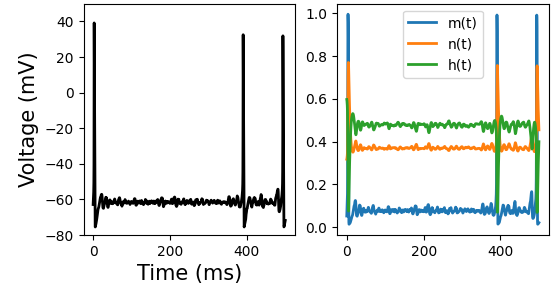

Now let's generate the f-I plot.

In [ ]:
# Now, iterate over different I and different noise to get the "spike rate - I" plot
fig, ax = plt.subplots(figsize = (5, 5))

sigma_list = [0, 0.5, 1.0, 2.0]
np.random.seed(42)
for sigma in sigma_list:
  T_total = 500 # ms
  t = np.linspace(0, T_total, 10000)

  # Set a range of current inputs
  I_current_list = np.arange(1, 20, 1)
  t_current_start = 0 # input current pulse will start at this time
  t_current_end   = T_total # input current pulse will end at this time

  # Preallocate a vector for storing the spike counts and peak amplitudes
  spike_rate = np.zeros(len(I_current_list))

  for i_idx, I_current in enumerate(I_current_list):
      # TODO: Implement the simulation by your own
      ...

      peaks, _ = find_peaks(V, height=0)
      # TODO: convert the number of spikes into spike rates in s^-1
      spike_rate[i_idx] = ...
      print("Input Current = {} μA/cm$^2$, sigma={}, spike rate = {} s^-1".format(I_current, sigma, spike_rate[i_idx]))
  plt.plot(I_current_list, spike_rate, '-o', label=f"sigma={sigma}")
plt.xlabel('Applied Current (μA/cm$^2$)')
plt.ylabel('Avg Spike Rate (s^-1)')
plt.title("F-I curve")
plt.legend()
plt.show()

The following is the plot we generated.

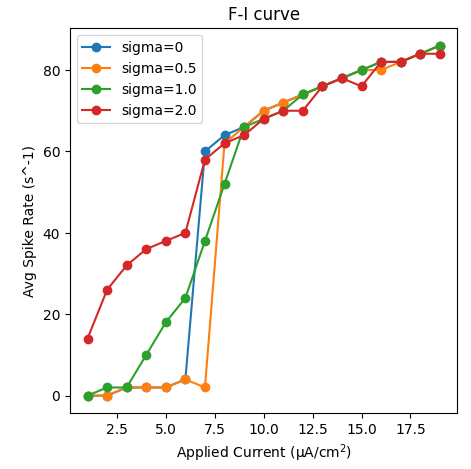



Explain the f-I curve when sigma is greater than 0.

For what values of $I$ does $\sigma$ affect the frequency of spikes $f$, and for what values of $I$ it does not affect $f$?

Explain your answer based on what we learned about the H-H equations.

## 1.6 (Bonus) Interspike Interval Characterization (15 points)

Consider the noise HH neurons simulted above, and:
- Plot the inter-spike-interval (ISI) distribution of the neuron
- Describe in words what the inter-spike-interval distribution would be if the input was constant (with no noise)?

Note: The ISI can be calculate using the `np.diff` function over the identified peaks